# Wine Dataset

In [251]:
from sklearn.datasets import load_wine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

In [163]:
wine_data = load_wine(as_frame=True)
wine_df = wine_data.frame
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


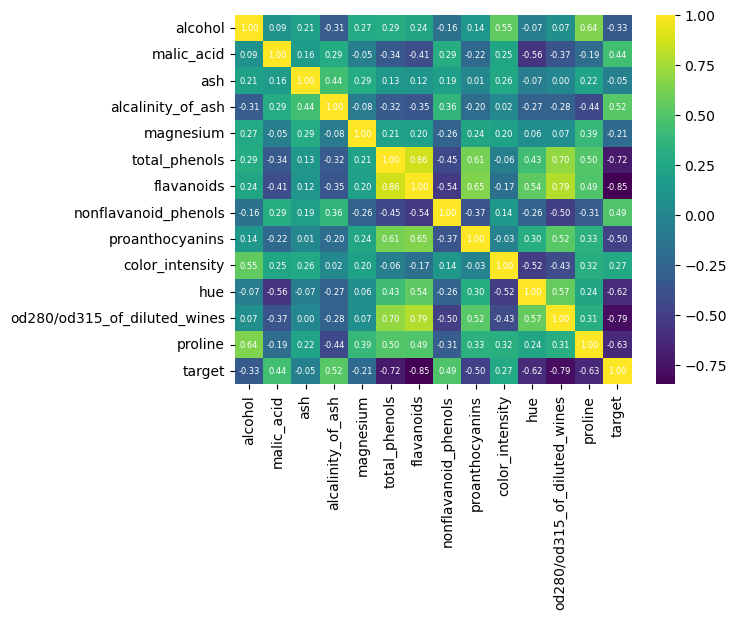

In [164]:
corr_matrix = wine_df.corr()
sns.heatmap(corr_matrix, cmap='viridis', annot=True, fmt=".2f", annot_kws={"size": 6, "color": "white"})
plt.show()

In [165]:
corr_matrix_abs = wine_df.drop(columns='target').corr().abs()

# Set the threshold for highly correlated features
threshold = 0.7

# List of highly correlated features
high_corr_features = np.where(corr_matrix_abs > threshold)
high_corr_pairs = [(corr_matrix_abs.index[x], corr_matrix_abs.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
high_corr_pairs

[('total_phenols', 'flavanoids'),
 ('flavanoids', 'od280/od315_of_diluted_wines')]

In [180]:
wine_df = wine_df.drop(columns=['flavanoids'])
X_df = wine_df.drop(columns='target')
y_df = wine_df['target']

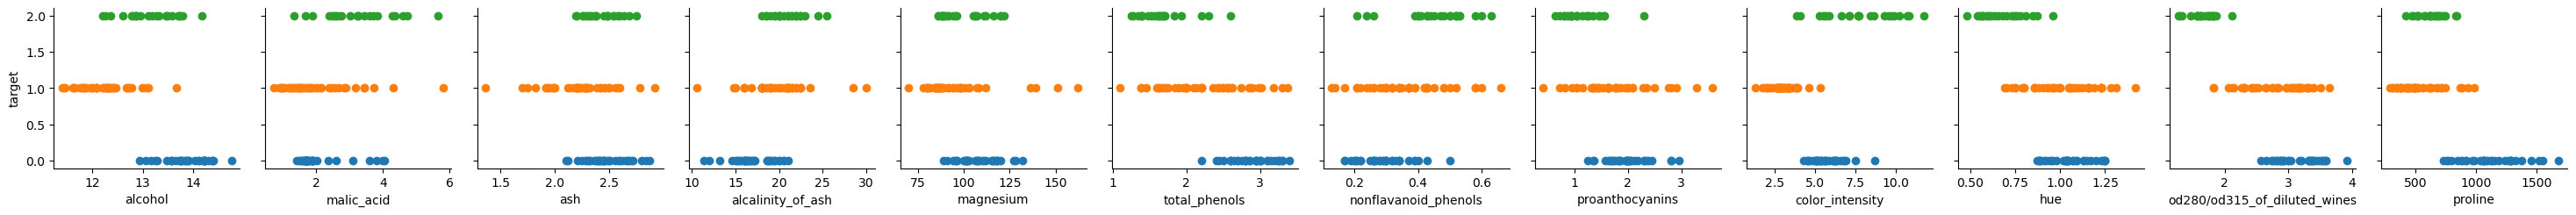

In [100]:
sample_size = 100
sampled_df = wine_df.sample(n=sample_size, random_state=1)
grid = sns.PairGrid(data=sampled_df, y_vars=['target'], x_vars=sampled_df.columns.drop(labels='target'), hue='target')
grid.map(plt.scatter)
plt.show()

In [266]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_df, y_df)
importances = forest.feature_importances_
indices_desc = np.argsort(importances)[::-1]
importances = importances[indices_desc] / importances.max()
imp_features_desc = X_df.columns[indices_desc]

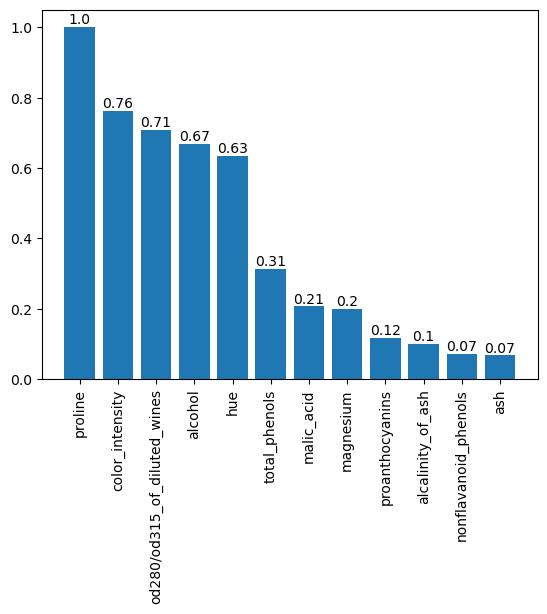

In [267]:
int_idx = np.arange(indices_desc.shape[0])
bars = plt.bar(int_idx, importances)
bar_idx = 0
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, round(yval, 2), ha='center', va='bottom', fontsize=10)
    bar_idx += 1
plt.xticks(int_idx, imp_features_desc, rotation=90)
plt.show()

In [240]:
X_df = X_df[imp_features_desc]     # Sorting features dataframe according to their importance

In [243]:
X_df.head()

,color_intensity,proline,od280/od315_of_diluted_wines,alcohol,hue,total_phenols,malic_acid,proanthocyanins,magnesium,alcalinity_of_ash,ash,nonflavanoid_phenols
0,5.64,1065.0,3.92,14.23,1.04,2.80,1.71,2.29,127.0,15.6,2.43,0.28
1,4.38,1050.0,3.40,13.20,1.05,2.65,1.78,1.28,100.0,11.2,2.14,0.26
2,5.68,1185.0,3.17,13.16,1.03,2.80,2.36,2.81,101.0,18.6,2.67,0.30
3,7.80,1480.0,3.45,14.37,0.86,3.85,1.95,2.18,113.0,16.8,2.50,0.24
4,4.32,735.0,2.93,13.24,1.04,2.80,2.59,1.82,118.0,21.0,2.87,0.39


In [273]:
subset_results = []
# ft_to_rem = X_df.shape[1] - 1
threshold = 0.4     # Remove features whose importance is less than 40% of the most imp feature
ft_to_rem = np.sum(importances < threshold)
mm = MinMaxScaler()
sample_size = X_df.shape[0]
np.random.seed(42)
random_samples = np.random.choice(X_df.index, size=sample_size, replace=False)
X_df_sampled = X_df.loc[random_samples]
y_df_sampled = y_df.loc[random_samples]
X_main_df, X_test_df, y_main_df, y_test_df = train_test_split(X_df_sampled, y_df_sampled, test_size=0.2, random_state=11, stratify=y_df_sampled)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_main_df, y_main_df, test_size=0.1, random_state=42, stratify=y_main_df)
mm.fit(X_train_df)
X_train = mm.transform(X_train_df)
y_train = y_train_df.values
X_val = mm.transform(X_val_df)
y_val = y_val_df.values
X_test = mm.transform(X_test_df)
y_test = y_test_df.values
k = int(np.floor(np.sqrt(X_train.shape[0])))
knn = KNeighborsClassifier(n_neighbors=k)
for i in range(0, ft_to_rem+1):
    if i > 0:
        X_train_filtered = X_train[:, :-i]
        X_val_filtered = X_val[:, :-i]
    else:
        X_train_filtered = X_train
        X_val_filtered = X_val
    knn.fit(X_train_filtered, y_train)
    accuracy = round(knn.score(X_val_filtered, y_val) * 100, 2)
    subset_results.append({
        'features_dropped': i,
        'val_accuracy': accuracy
    })
    print(f'Trial #{i}\n')
    print(f'Features Dropped: {i}')
    print(f'Validation Accuracy: {accuracy}\n\n')

subset_results = sorted(subset_results, key=lambda x: (-x['val_accuracy'], -x['features_dropped']))
print('Best Subset')
print(f"Features Dropped: {subset_results[0]['features_dropped']}")
print(f"Dropped Feature Names: {list(X_df.columns[-subset_results[0]['features_dropped']:])}")
print(f"Validation Accuracy: {subset_results[0]['val_accuracy']}\n\n")

X_test_filtered = X_test[:, :-subset_results[0]['features_dropped']]
X_train_filtered = X_train[:, :-subset_results[0]['features_dropped']]

Trial #0

Features Dropped: 0
Validation Accuracy: 93.33


Trial #1

Features Dropped: 1
Validation Accuracy: 93.33


Trial #2

Features Dropped: 2
Validation Accuracy: 93.33


Trial #3

Features Dropped: 3
Validation Accuracy: 93.33


Trial #4

Features Dropped: 4
Validation Accuracy: 86.67


Trial #5

Features Dropped: 5
Validation Accuracy: 86.67


Trial #6

Features Dropped: 6
Validation Accuracy: 86.67


Trial #7

Features Dropped: 7
Validation Accuracy: 93.33


Best Subset
Features Dropped: 7
Dropped Feature Names: ['total_phenols', 'malic_acid', 'proanthocyanins', 'magnesium', 'alcalinity_of_ash', 'ash', 'nonflavanoid_phenols']
Validation Accuracy: 93.33




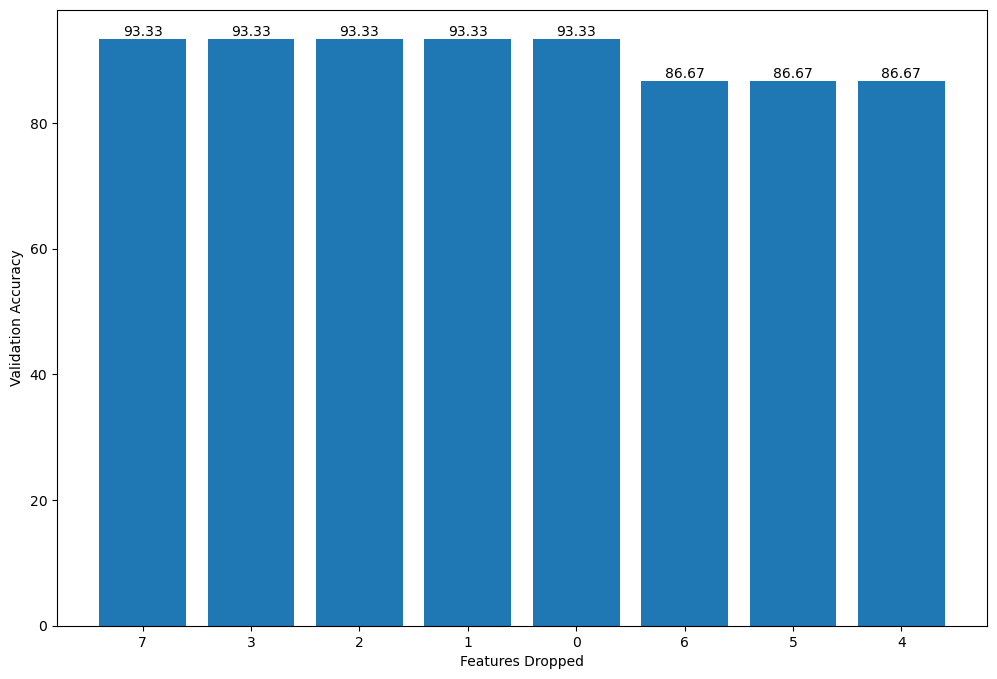

In [274]:
val_accuracy = map(lambda x: x['val_accuracy'], subset_results)
val_accuracy = list(val_accuracy)
ft_dropped = map(lambda x: x['features_dropped'], subset_results)
ft_dropped = list(ft_dropped)
idx = np.arange(0, len(subset_results))
plt.figure(figsize=(12, 8))
bars = plt.bar(idx, val_accuracy)
plt.xlabel('Features Dropped')
plt.ylabel('Validation Accuracy')
plt.xticks(idx, ft_dropped)
# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.show()

In [257]:
model = tf.keras.Sequential([
    tf.keras.Input(shape= (X_train.shape[1],) ),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=3, kernel_regularizer=tf.keras.regularizers.L2(0.01))
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2342 - loss: 1.4523
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3114 - loss: 1.4153 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3272 - loss: 1.4155 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5005 - loss: 1.3906 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5090 - loss: 1.3776 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5393 - loss: 1.3695 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6144 - loss: 1.3469 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6113 - loss: 1.3326 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6270 - loss: 1.3123 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6051 - loss: 1.3062 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6259 - loss: 1.2859  
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6186 - los

In [272]:
model = tf.keras.Sequential([
    tf.keras.Input(shape= (X_train_filtered.shape[1],) ),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=3, kernel_regularizer=tf.keras.regularizers.L2(0.01))
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(
    X_train_filtered,
    y_train,
    batch_size=32,
    epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4473 - loss: 1.3684
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4974 - loss: 1.3368
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4943 - loss: 1.3269  
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4713 - loss: 1.3153  
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5005 - loss: 1.2981 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5256 - loss: 1.2877 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5068 - loss: 1.2743 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5183 - loss: 1.2554 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5485 - loss: 1.2359 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5590 - loss: 1.2168 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5528 - loss: 1.2145 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6028 - lo